<h2 align=center> Facial Expression Recognition</h2>

### Import Libraries

In [4]:
#Import the necessary libraries

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.5.0


### See the random sample images in the dataset

In [8]:
def show_images(plt):
    image_size = 48
    plt.figure(0, figsize = (12,20))
    image_position = 0
    
    #Loop among the 7 classes in the train set
    for expression in os.listdir("train/"):
        #Loop among five random images in the train set
        for i in range(1,6):
            if i== 2:
                plt.ylabel(expression,fontsize=20)
            index= np.random.randint(1,400)
            image_position += 1
            plt.subplot(7, 5, image_position)
            image = load_img("train/"+ expression + "/" + os.listdir("train/" + expression)[index], target_size = (image_size, image_size))
            plt.imshow(image, cmap="gray")
    plt.tight_layout
    return plt

In [10]:
show_images(plt).show()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'train/'

<Figure size 864x1440 with 0 Axes>

### Check whether the set is balanced

In [8]:
#Looping among the 7 classes in the dataset
total = 0
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")
    total += len(os.listdir("train/" + expression))
print("The total number of images in the train set is ",total)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'train/'

###  Generate training and validation Batches

In [5]:
image_size = 48
batch_size = 64

#Data augmentation is done by flipping the image horizontally
datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(image_size, image_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                    target_size=(image_size, image_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Create the structure of CNN Model

In [6]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Training and Evaluating the model in live

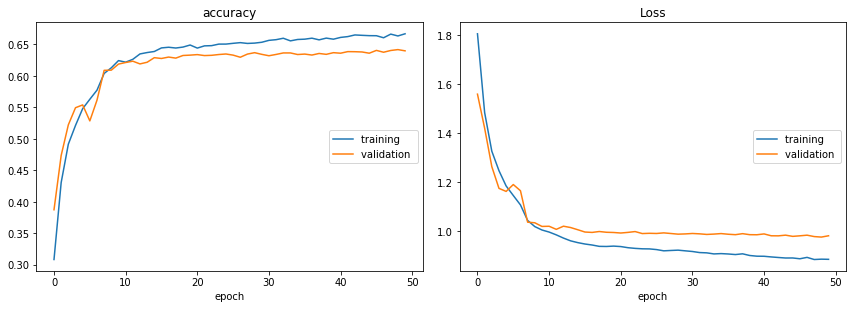

accuracy
	training         	 (min:    0.308, max:    0.667, cur:    0.667)
	validation       	 (min:    0.387, max:    0.642, cur:    0.640)
Loss
	training         	 (min:    0.885, max:    1.806, cur:    0.885)
	validation       	 (min:    0.976, max:    1.559, cur:    0.982)

Epoch 00050: saving model to model_weights.h5
448/448 [==============================] - 609s 1s/step - loss: 0.8855 - accuracy: 0.6670 - val_loss: 0.9815 - val_accuracy: 0.6399
Wall time: 8h 35min 49s


In [7]:
%%time

epochs = 50
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.00001, mode = 'auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor ='val_accuracy', save_weights_only = True, mode ='max', verbose = 1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Represent Model as serialized JSON String

In [13]:
model_json = model.to_json()
with open("model_anson.json", "w") as json_file:
    json_file.write(model_json)

In [12]:
os.getcwd()

'D:\\main\\My works\\Project\\Emotion Facial Recognition\\Project'